In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data
import numpy as np
import nnfs
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from tools.nets import Layer_Dense

nnfs.init()
np.random.seed(42)
torch.manual_seed(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(42) # Set seed for GPU if available

In [2]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'NVIDIA GeForce RTX 4070 Laptop GPU')

## Backpropagation algorithm

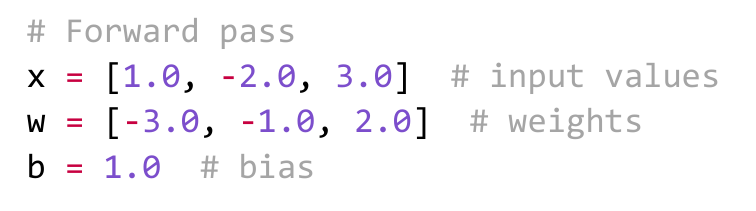

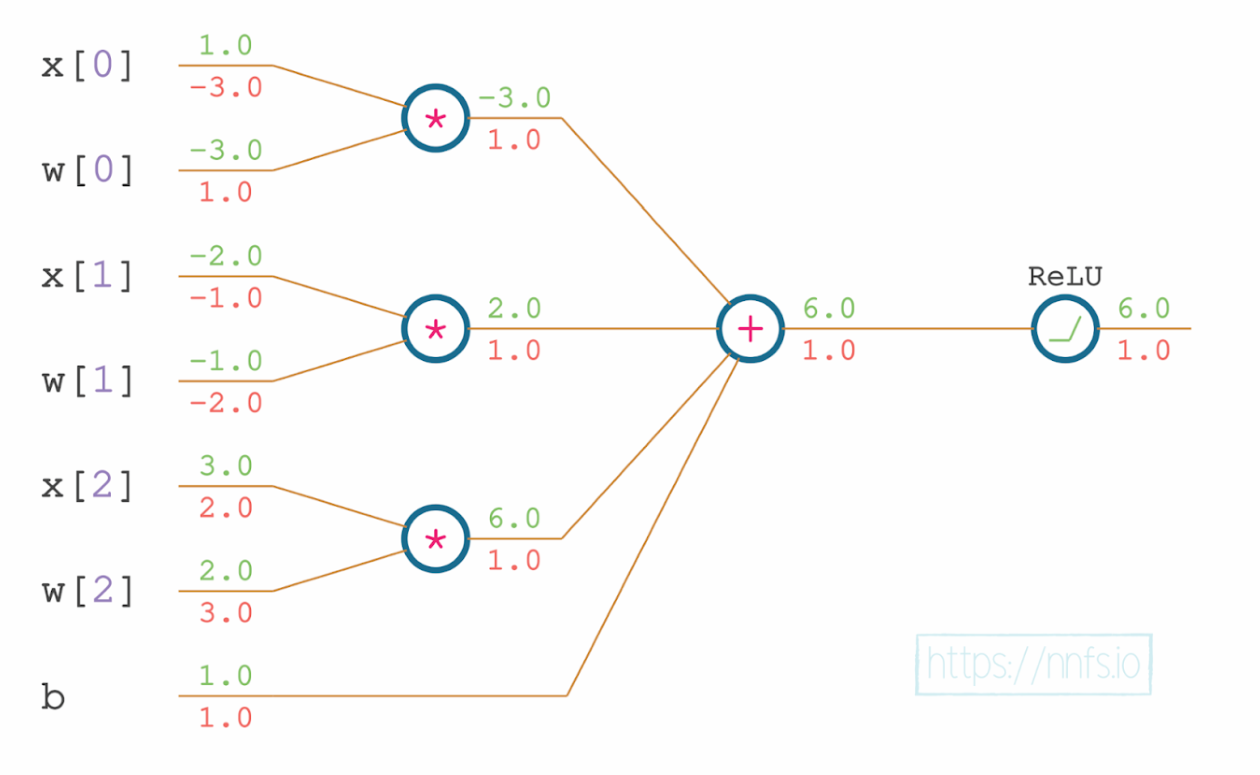

### Chain rule:

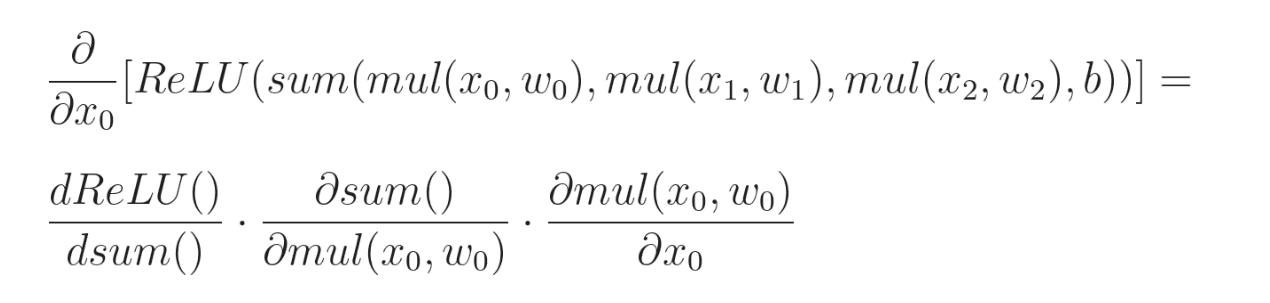

### Relu derivative

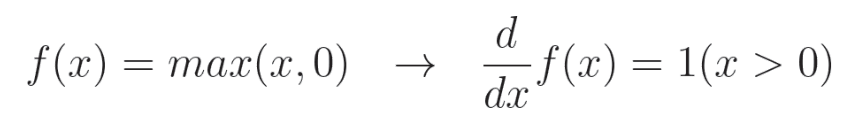

$$
\text{dReLU}(z) = 
\begin{cases}
1 & \text{if } z > 0 \\
0 & \text{otherwise}
\end{cases}
$$

# 🔁 Backpropagation Step-by-Step

---

## 🧠 Forward Pass

We compute the output $ y $ of the neuron using:

$$
z = \sum_i x[i] \cdot w[i] + b
\quad \Rightarrow \quad
y = \text{ReLU}(z)
$$

From the diagram:

- $ x = [1, -2, 3] $
- $ w = [-3, -1, 2] $
- $ b = 1 $

### Step-by-step:

$$
\begin{aligned}
x[0] \cdot w[0] &= 1 \cdot (-3) = -3 \\
x[1] \cdot w[1] &= -2 \cdot (-1) = 2 \\
x[2] \cdot w[2] &= 3 \cdot 2 = 6 \\
z &= -3 + 2 + 6 + 1 = 6 \\
y &= \text{ReLU}(6) = \max(0, 6) = 6
\end{aligned}
$$

---

## 🎯 Assume a Loss Function

Assume a mean squared error loss:

$$
L = \frac{1}{2}(y_{\text{pred}} - y_{\text{true}})^2
$$

Assume $ \frac{\partial L}{\partial y} = 1 $ (as given).

We will now compute:

- $ \frac{\partial L}{\partial w[i]} $
- $ \frac{\partial L}{\partial x[i]} $
- $ \frac{\partial L}{\partial b} $

---

## 🔁 Step-by-Step Backpropagation

### Step 1: Derivative through ReLU

$$
\frac{\partial y}{\partial z} =
\begin{cases}
1 & \text{if } z > 0 \\
0 & \text{otherwise}
\end{cases}
\Rightarrow \frac{\partial y}{\partial z} = 1 \quad (\text{since } z = 6 > 0)
$$

Then:

$$
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial z} = 1 \cdot 1 = 1
$$

---

### Step 2: Gradient w.r.t. Weights

$$
\frac{\partial z}{\partial w[i]} = x[i] \Rightarrow \frac{\partial L}{\partial w[i]} = \frac{\partial L}{\partial z} \cdot x[i]
$$

$$
\begin{aligned}
\frac{\partial L}{\partial w[0]} &= 1 \cdot x[0] = 1 \\
\frac{\partial L}{\partial w[1]} &= 1 \cdot x[1] = -2 \\
\frac{\partial L}{\partial w[2]} &= 1 \cdot x[2] = 3
\end{aligned}
$$

---

### Step 3: Gradient w.r.t. Inputs

$$
\frac{\partial z}{\partial x[i]} = w[i] \Rightarrow \frac{\partial L}{\partial x[i]} = \frac{\partial L}{\partial z} \cdot w[i]
$$

$$
\begin{aligned}
\frac{\partial L}{\partial x[0]} &= 1 \cdot w[0] = -3 \\
\frac{\partial L}{\partial x[1]} &= 1 \cdot w[1] = -1 \\
\frac{\partial L}{\partial x[2]} &= 1 \cdot w[2] = 2
\end{aligned}
$$

---

### Step 4: Gradient w.r.t. Bias

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial b} = 1 \cdot 1 = 1
$$

---

## ✅ Final Gradients Summary

| Parameter    | Gradient              |
|--------------|-----------------------|
| $ w[0] $   | $ \frac{\partial L}{\partial w[0]} = 1 $ |
| $ w[1] $   | $ \frac{\partial L}{\partial w[1]} = -2 $ |
| $ w[2] $   | $ \frac{\partial L}{\partial w[2]} = 3 $ |
| $ x[0] $   | $ \frac{\partial L}{\partial x[0]} = -3 $ |
| $ x[1] $   | $ \frac{\partial L}{\partial x[1]} = -1 $ |
| $ x[2] $   | $ \frac{\partial L}{\partial x[2]} = 2 $ |
| $ b $      | $ \frac{\partial L}{\partial b} = 1 $ |

</br>

---

> **Why not calculate derivatives with respect to the outputs of the first layer (the sums before the final addition)?**

Those intermediate values (the outputs of the multiplications $ x[i] \cdot w[i] $) are part of the computation graph. So let’s clarify **why we don’t usually take derivatives with respect to those sums**, and **when we actually do**.

---

## 🧩 The Structure of the Computation Graph

Here’s a simplified breakdown of the forward pass from the diagram:

$$
z = x[0]w[0] + x[1]w[1] + x[2]w[2] + b
\Rightarrow y = \text{ReLU}(z)
$$

### In detail:
Let:
- $ m_0 = x[0] \cdot w[0] $
- $ m_1 = x[1] \cdot w[1] $
- $ m_2 = x[2] \cdot w[2] $

Then:

$$
z = m_0 + m_1 + m_2 + b
$$

---

## 🔁 Backpropagation’s Goal

The **goal of backpropagation** is to compute gradients of the loss with respect to the model's **parameters** — like $ w[i] $, $ b $, and maybe $ x[i] $ if we're doing something like input attribution.

We don’t *usually* need to compute:

$$
\frac{\partial L}{\partial m_i}
$$

But we *could*, especially for debugging or explaining intermediate steps!

---

## 🧮 Let's Compute It Anyway!

Let’s say:

$$
L \rightarrow y \rightarrow z \rightarrow m_i = x[i]w[i]
$$

Then using the chain rule:

$$
\frac{\partial L}{\partial m_i} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial m_i}
= \frac{\partial L}{\partial z} \cdot 1 = 1
$$

(because $ z = m_0 + m_1 + m_2 + b $, so each $ \frac{\partial z}{\partial m_i} = 1 $)

Now if you wanted to go **further** back to $ w[i] $ and $ x[i] $, you'd apply:

$$
\frac{\partial m_i}{\partial w[i]} = x[i]
\quad\text{and}\quad
\frac{\partial m_i}{\partial x[i]} = w[i]
$$

So in practice:
$$
\frac{\partial L}{\partial w[i]} = \frac{\partial L}{\partial m_i} \cdot \frac{\partial m_i}{\partial w[i]} = 1 \cdot x[i]
$$
Same goes for $ x[i] $.

---

## 🧠 So Why Not Always Do This?

Because in most practical neural net frameworks and math notations:
- We **fuse** these operations to save time/memory.
- We **already know the structure** of how $ z $ is computed (it’s linear), so we can directly differentiate $ z $ w.r.t. $ w[i] $, $ x[i] $, or $ b $ **without explicitly naming the intermediate products**.

But it's 100% valid and often helpful to think in those intermediate steps, especially if you're:
- Building a framework from scratch
- Debugging a gradient issue
- Teaching or explaining the chain rule

---

### TL;DR

You **can** calculate derivatives w.r.t. those intermediate multiplication results (the "sums of the first layer"), and sometimes it’s useful for clarity. But it's usually skipped because we go straight to the gradients of the loss w.r.t. the parameters using known derivatives of the full expression.